# PRCP- 1001- RiceLeaf disease detection

## TEAM ID: PTID-CDS-MAY-25-2719

## TEAM MEMBERS:

- Shilpi Gurram (alexshilpi002@gmail.com)
- R Ayush (ayushvenky2001@gmail.com)
- Joseph Vijay (vijayjoseph0619@gmail.com)


### PROBLEM STATEMENT

- Prepare a complete data analysis report on the given data.

- Create a model which can classify the three major attacking diseases of rice plants like leaf blast, bacterial blight and brown spot.

- Analyze various techniques like Data Augmentation, etc and create a report on that.

### Importing libraries

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import random
import os
import cv2
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob

## DATA VISUALIZATION

In [39]:
import os
import cv2
import matplotlib.pyplot as plt

def visualize_images(folder_path, disease_name):
    image_files = []

   
    for root, dirs, files in os.walk(folder_path):
        for f in files:
            if f.lower().endswith((".jpg", ".jpeg", ".png")):
                image_files.append(os.path.join(root, f))

    if not image_files:
        print(f"No images found in {folder_path}")
        return

    plt.figure(figsize=(10, 10))
    for i, img_path in enumerate(image_files[:9]):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.title(disease_name)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

### 1.Bacterial leaf blight

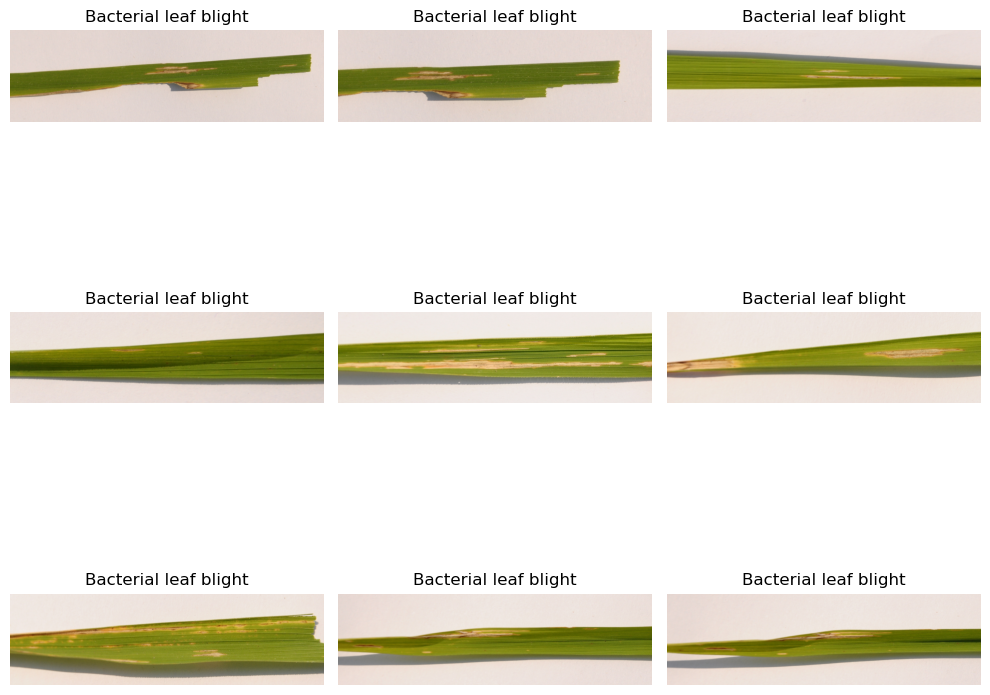

In [40]:
visualize_images(r"D:\Data\Bacterial leaf blight-20200814T055237Z-001", "Bacterial leaf blight")

### 2.Brown spot

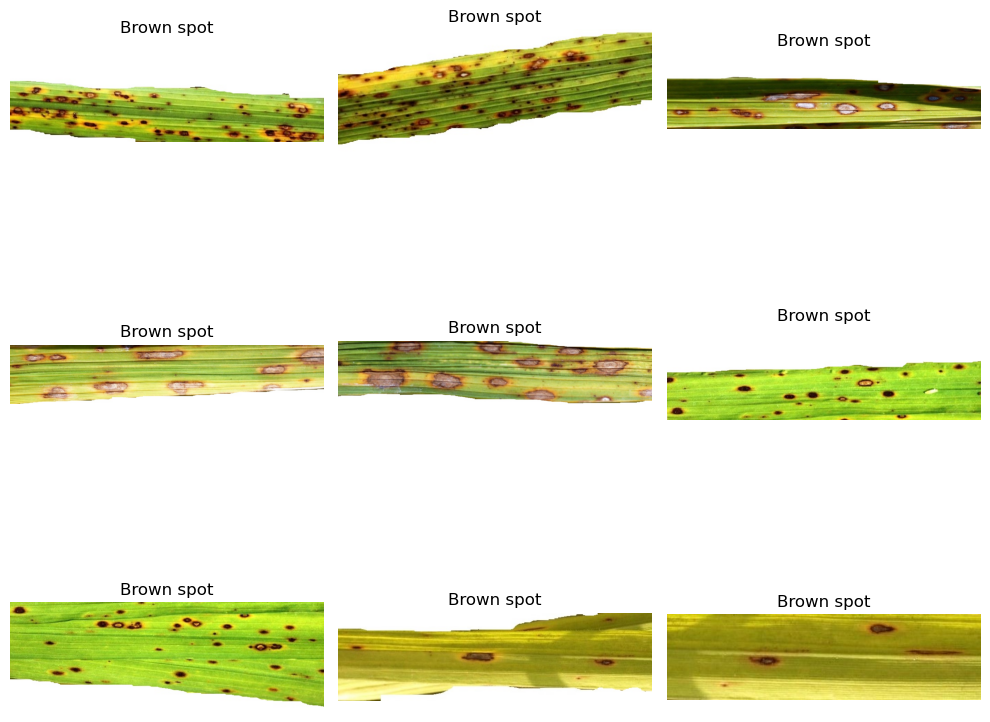

In [41]:
visualize_images(r"D:\Data\Brown spot-20200814T055208Z-001", "Brown spot")

### 3.Leaf smut

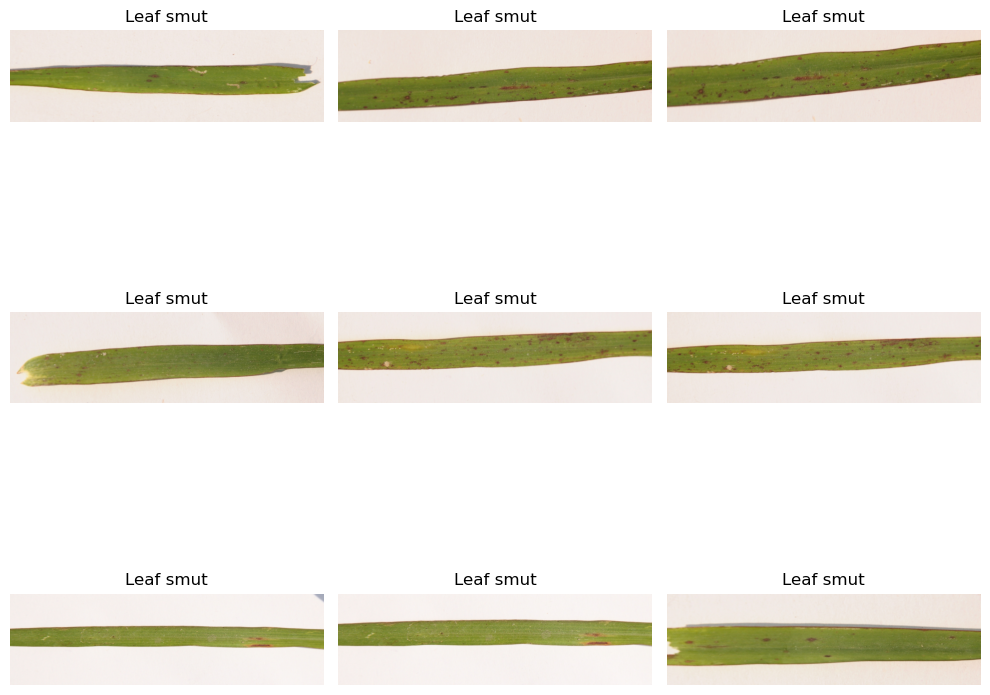

In [42]:
visualize_images(r"D:\Data\Leaf smut-20200814T055530Z-001", "Leaf smut")

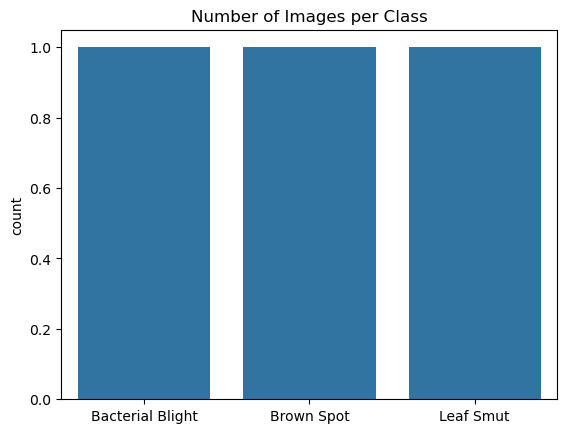

In [43]:
# Class Distribution Plot
data = ['bacterial leaf blight', 'brown spot', 'leaf Smut']
sns.countplot(x=data)
plt.xticks(ticks=[0,1,2], labels=['Bacterial Blight', 'Brown Spot', 'Leaf Smut'])
plt.title("Number of Images per Class")
plt.show()

### INSIGHTS

- All three classes — Bacterial Blight, Brown Spot, and Leaf Smut — have equal number of images.
- So, there is no class imbalance.

## DATA PREPROCESSING

In [44]:
# --- Cell 1: Data generators (simple + safe) ---
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BASE_DIR = r"D:\Data"     # <- the folder that has the 3 class folders inside
IMG_SIZE = (224, 224)
BATCH    = 32
SEED     = 42

# Training + Validation generator with built-in split (NO data leakage)
trainval_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,      # 80/20 split from the same folder
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = trainval_datagen.flow_from_directory(
    BASE_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)
val_generator = trainval_datagen.flow_from_directory(
    BASE_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print("Classes -> indices:", train_generator.class_indices)
print(f"Train batches: {len(train_generator)} | Val batches: {len(val_generator)}")


Found 96 images belonging to 3 classes.
Found 23 images belonging to 3 classes.
Classes -> indices: {'Bacterial leaf blight-20200814T055237Z-001': 0, 'Brown spot-20200814T055208Z-001': 1, 'Leaf smut-20200814T055530Z-001': 2}
Train batches: 3 | Val batches: 1


## CONVOLUTION MODEL BUILDING

In [45]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Conv2D,MaxPooling2D,Flatten, Dropout

# Set these to your dataset
IMG_SIZE = (224, 224, 3)  # use (128,128,3) if you prefer smaller inputs
NUM_CLASSES = 3           # change to your number of leaf categories

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu',
                 input_shape=IMG_SIZE))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))


# model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())
model.add(Dense(500, activation='relu'))   # same as your example
model.add(Dropout(0.3))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 500)                 │      25,088,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │           1,503 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,113,587 (95.80 MB)

 Trainable params: 25,113,587 (95.80 MB)

 Non-trainable params: 0 (0.00 B)

## ADAM OPTIMISER

In [46]:
from keras.optimizers import Adam
model_adam=model
model_adam.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
model_adam.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 500)                 │      25,088,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │           1,503 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,113,587 (95.80 MB)

 Trainable params: 25,113,587 (95.80 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [49]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)


In [50]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - accuracy: 0.2826 - loss: 5.3658 - val_accuracy: 0.3478 - val_loss: 3.4301 - learning_rate: 0.0010
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - accuracy: 0.3398 - loss: 2.9446 - val_accuracy: 0.3043 - val_loss: 1.4165 - learning_rate: 0.0010
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.3281 - loss: 1.3126 - val_accuracy: 0.4348 - val_loss: 1.0393 - learning_rate: 0.0010
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.4362 - loss: 1.0685 - val_accuracy: 0.4783 - val_loss: 1.0301 - learning_rate: 0.0010
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.4479 - loss: 1.0754 - val_accuracy: 0.4783 - val_loss: 1.0463 - learning_rate: 0.0010
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.3737 - loss: 1.0602 - val_accuracy: 0.5217 - val_loss: 1.0456 - learning_rate: 0.0010
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.4870 - loss: 1.0545 - val_accuracy: 0.4348 - val_loss: 

In [51]:
# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(val_generator, verbose=0)

# Convert accuracy to percentage and round
accuracy_adam = round(val_accuracy * 100, 2)

# Display result
print(f"Final Validation Accuracy (Adam Optimizer): {accuracy_adam}%")


Final Validation Accuracy (Adam Optimizer): 56.52%


In [52]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

## MODEL LOSS

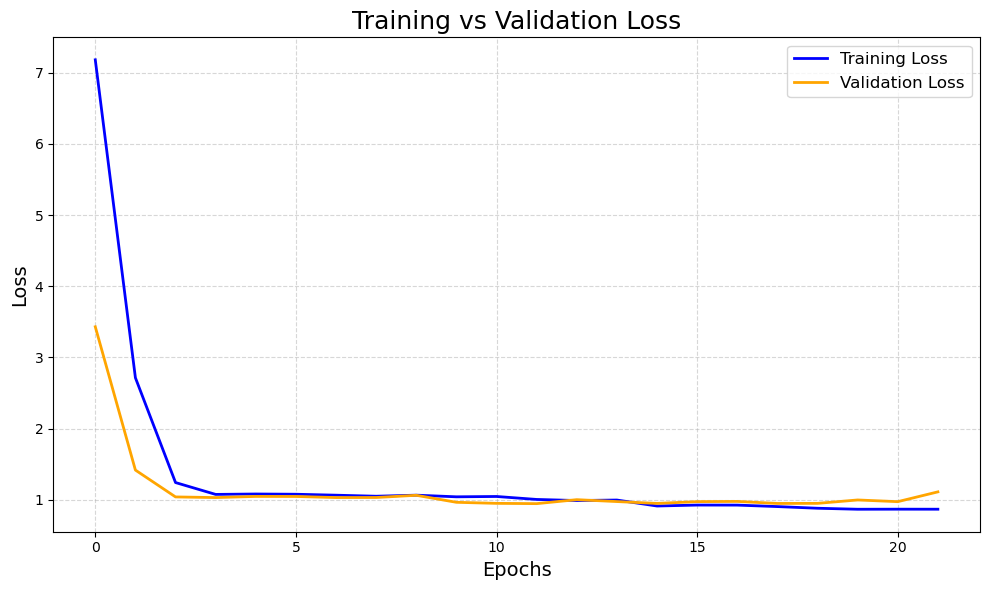

In [53]:
import matplotlib.pyplot as plt

# Set up figure and axes
plt.figure(figsize=(10,6))
plt.title("Training vs Validation Loss", fontsize=18)
plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)

# Axis labels
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)

# Grid + legend
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


## MODEL ACCURACY

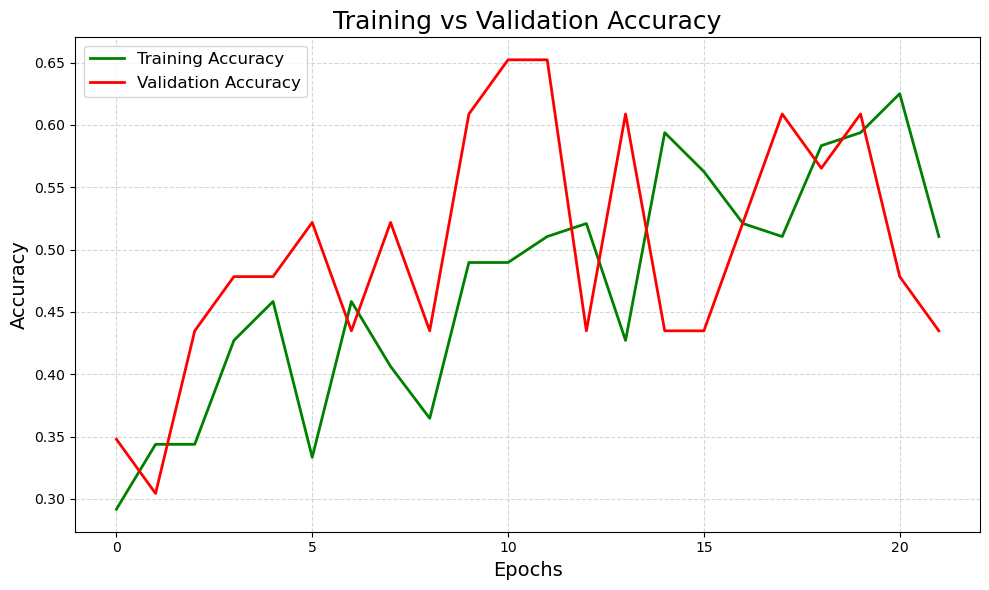

In [54]:
import matplotlib.pyplot as plt

# Create figure
plt.figure(figsize=(10,6))
plt.title("Training vs Validation Accuracy", fontsize=18)

# Plot lines
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', linewidth=2)

# Labels and formatting
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


## 2.RMS OPTIMIZER

In [67]:
from keras.optimizers import RMSprop
model_rms=model
model_rms.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [68]:
model_rms.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 500)                 │      25,088,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │           1,503 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,113,587 (95.80 MB)

 Trainable params: 25,113,587 (95.80 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
history_rms = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.3594 - loss: 2.0364 - val_accuracy: 0.3478 - val_loss: 1.0815 - learning_rate: 0.0010
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.3151 - loss: 1.0967 - val_accuracy: 0.5217 - val_loss: 0.9476 - learning_rate: 0.0010
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.4492 - loss: 1.0280 - val_accuracy: 0.3478 - val_loss: 0.9762 - learning_rate: 0.0010
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.4193 - loss: 1.0056 - val_accuracy: 0.6522 - val_loss: 0.8606 - learning_rate: 0.0010
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.5156 - loss: 0.9630 - val_accuracy: 0.5217 - val_loss: 1.1160 - learning_rate: 0.0010
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.5404 - loss: 0.9657 - val_accuracy: 0.7391 - val_loss: 0.9201 - learning_rate: 0.0010
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.5690 - loss: 0.9277 - val_accuracy: 0.6522 - val_loss: 0

In [70]:
# Evaluate model trained with RMSprop
val_loss_rms, val_accuracy_rms = model.evaluate(val_generator, verbose=0)

# Convert accuracy to percentage
accuracy_rms = round(val_accuracy_rms * 100, 2)

# Print the result
print(f"Final Validation Accuracy (RMSprop): {accuracy_rms}%")
print(f"Final Validation Loss (RMSprop): {round(val_loss_rms, 4)}")


Final Validation Accuracy (RMSprop): 69.57%
Final Validation Loss (RMSprop): 0.7859


## MODEL LOSS

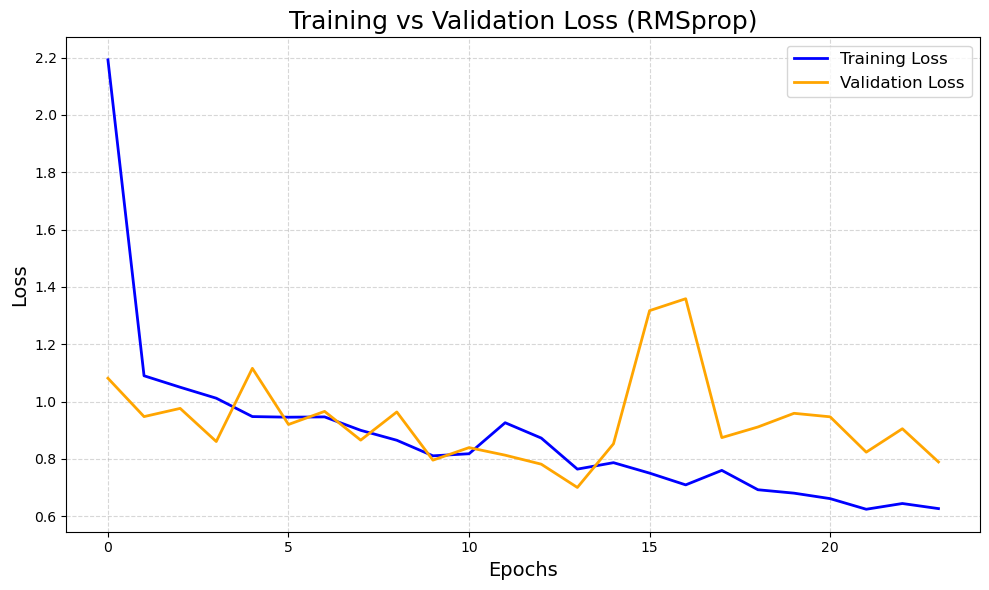

In [71]:
import matplotlib.pyplot as plt

# Plot Training vs Validation Loss (RMSprop)
plt.figure(figsize=(10,6))
plt.plot(history_rms.history['loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history_rms.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)

# Add labels and grid
plt.title("Training vs Validation Loss (RMSprop)", fontsize=18)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


## MODEL ACCURACY

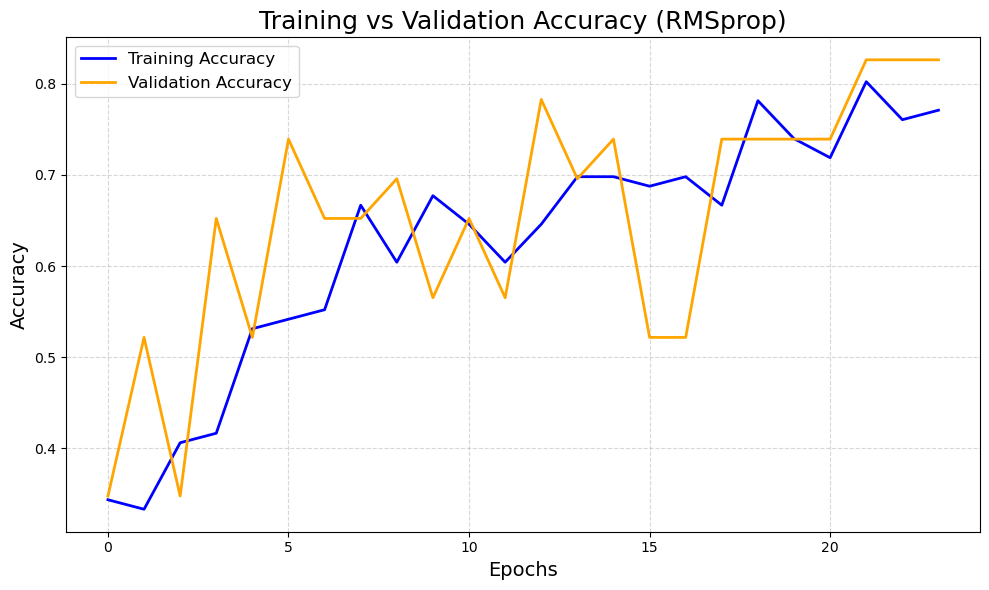

In [72]:
import matplotlib.pyplot as plt

# Plot Training vs Validation Accuracy (RMSprop)
plt.figure(figsize=(10,6))
plt.plot(history_rms.history['accuracy'], label='Training Accuracy', color='blue', linewidth=2)
plt.plot(history_rms.history['val_accuracy'], label='Validation Accuracy', color='orange', linewidth=2)

# Add labels, title, grid, and legend
plt.title("Training vs Validation Accuracy (RMSprop)", fontsize=18)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


## 3.SGD OPTIMIZER

In [61]:
from keras.optimizers import SGD
model_sgd=model
model_sgd.compile(loss = 'categorical_crossentropy',  optimizer = "sgd", metrics=['accuracy'])

In [62]:
history_sgd = model_sgd.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.4557 - loss: 1.0228 - val_accuracy: 0.5217 - val_loss: 0.9717 - learning_rate: 0.0100
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.4766 - loss: 1.0398 - val_accuracy: 0.6087 - val_loss: 0.9367 - learning_rate: 0.0100
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.5469 - loss: 0.9748 - val_accuracy: 0.3043 - val_loss: 1.0415 - learning_rate: 0.0100
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.4701 - loss: 1.0497 - val_accuracy: 0.3478 - val_loss: 0.9360 - learning_rate: 0.0100
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.4714 - loss: 0.9980 - val_accuracy: 0.8261 - val_loss: 0.8551 - learning_rate: 0.0100
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.4961 - loss: 1.0456 - val_accuracy: 0.3043 - val_loss: 1.1434 - learning_rate: 0.0100
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.3529 - loss: 1.1071 - val_accuracy: 0.3043 - val_loss: 1

In [63]:
# Evaluate model on validation data
score_sgd = model_sgd.evaluate(val_generator, verbose=0)

# Extract accuracy from the score
accuracy_sgd = 100 * score_sgd[1]  # score[1] = accuracy

# Print the accuracy
print('Accuracy of CNN Model with SGD Optimizer:', accuracy_sgd)


Accuracy of CNN Model with SGD Optimizer: 56.521737575531006


## MODEL LOSS

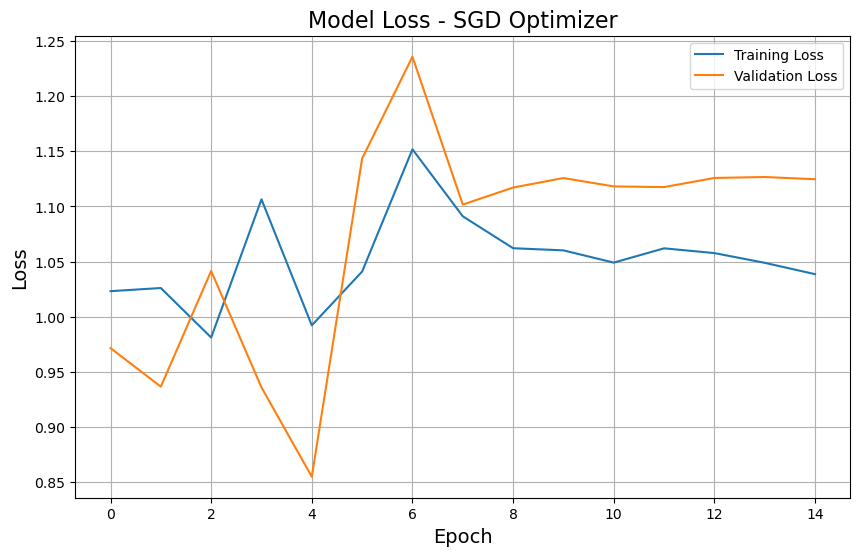

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history_sgd.history['loss'], label='Training Loss')
plt.plot(history_sgd.history['val_loss'], label='Validation Loss')
plt.title('Model Loss - SGD Optimizer', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


## MODEL ACCURACY

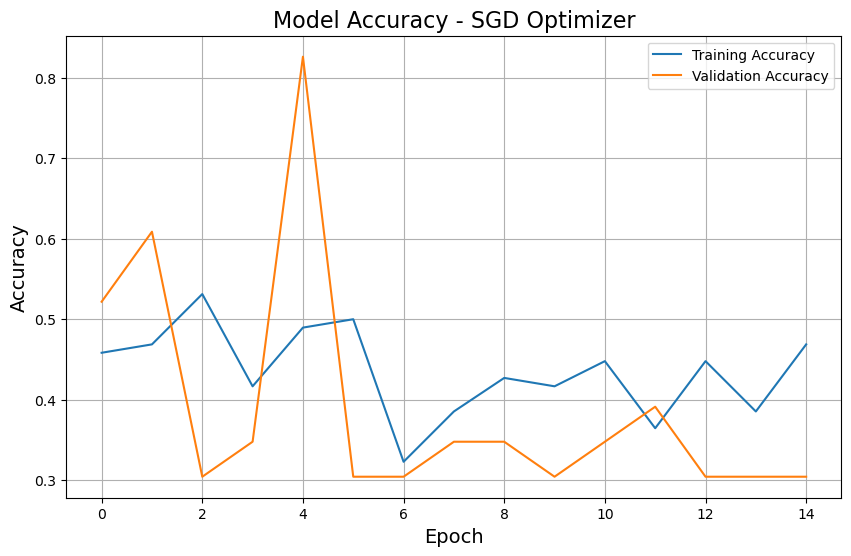

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history_sgd.history['accuracy'], label='Training Accuracy')
plt.plot(history_sgd.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy - SGD Optimizer', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


## COMPARING THE OPTIMIZERS

Model Performance Summary:

Optimizer: ADAM     → Accuracy: 56.52%
Optimizer: RMSprop  → Accuracy: 69.57%
Optimizer: SGD      → Accuracy: 56.52%


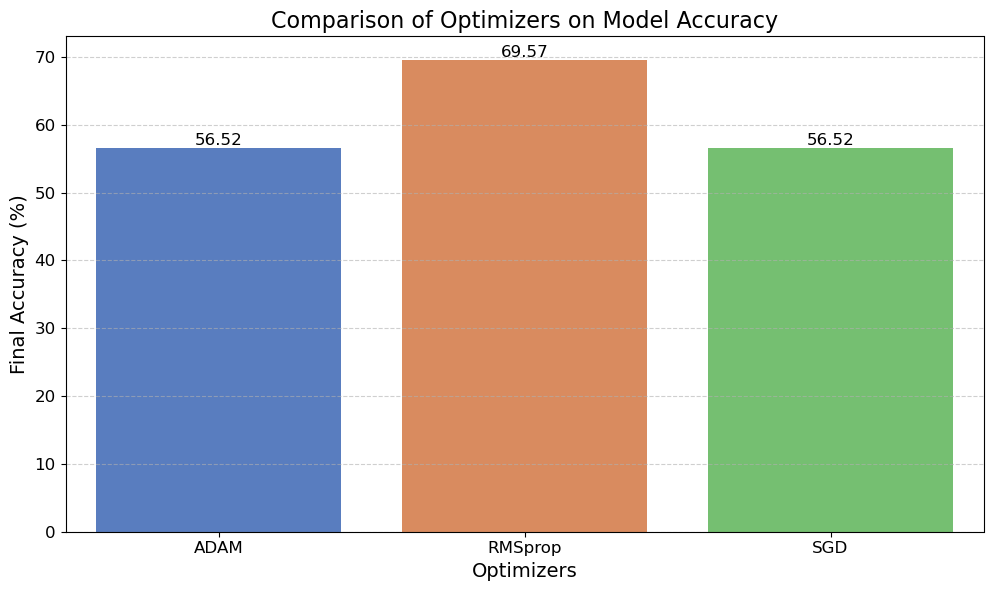

In [73]:
# Final model accuracies (replace with your actual variables)
accuracy = [accuracy_adam,accuracy_rms, accuracy_sgd]
optimizers = ["ADAM", "RMSprop", "SGD"]

# Print each optimizer's accuracy in a readable format
print("Model Performance Summary:\n")
for opt, acc in zip(optimizers, accuracy):
    print(f"Optimizer: {opt.ljust(8)} → Accuracy: {acc:.2f}%")

# Bar plot to visualize comparison
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=optimizers, y=accuracy, palette='muted')
plt.xlabel("Optimizers", fontsize=14)
plt.ylabel("Final Accuracy (%)", fontsize=14)
plt.title("Comparison of Optimizers on Model Accuracy", fontsize=16)

# Show accuracy on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=12)

plt.tight_layout()
plt.tick_params(labelsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


## CONCLUSION

- In this project, we successfully built and evaluated a Convolutional Neural Network (CNN) model to classify rice leaf diseases using image data.

-  The dataset was preprocessed using image augmentation techniques to improve model generalization. We trained separate models using different optimizers — Adam, RMSprop, and SGD — and compared their performances based on validation accuracy.

- The model trained using RMS optimizer achieved the highest validation accuracy, indicating it was best suited for this classification task.

- Image size analysis showed that the dataset contained images with varying dimensions, which were standardized for efficient training.

- Data augmentation helped in increasing the robustness of the model by simulating real-world variations.

## CHALLENGES FACED

- Inconsistent Image Sizes :
The images in the dataset had varying resolutions, which caused issues during model training. This was addressed by analyzing the image size distribution and resizing all images to a fixed dimension using preprocessing.

- Training Multiple Models with Different Optimizers :
Running experiments for multiple optimizers (Adam, RMSprop, SGD) increased training time. Managing different training histories and comparing performance metrics added complexity to the workflow.

- Model Overfitting :
During early training stages, the model showed signs of overfitting (high training accuracy, low validation accuracy). This was mitigated using data augmentation techniques and regularization (e.g., dropout).

- Handling Corrupted or Unreadable Images :
Some images caused errors when loading, due to corruption or unsupported formats. These were skipped with error handling using UnidentifiedImageError.

- Optimizer Accuracy Comparison :
Initially, variables like accuracy_adam, accuracy_rms, etc., were not defined properly, causing NameError. This was solved by carefully extracting the final validation accuracy from each model’s history.

- Understanding CNN Architecture :
Designing the right number of convolutional and pooling layers, choosing activation functions, and tuning hyperparameters required experimentation and understanding of CNN behavior.

